In [3]:
import scipy
import matplotlib.pyplot as plt
%matplotlib inline
import json
import numpy as np

In [109]:
with open('./ROS-CoppeliaSim/majorvibes/SimulationFiles/Demo Simulations/pulchowk_polys1_utm_buffer.geojson') as f:
  data = json.load(f)


polys = []

for feature in data["features"]:
        if feature["geometry"]["type"] == "Polygon":
	#subtracting offsets here, the offsets are in the geojson file
            featCoor = [[i[0]-data["offset"][0],i[1]-data["offset"][1]] for i in feature["geometry"]["coordinates"][0]]
            print(featCoor)
            polys.append(np.array(featCoor))

#polys_array = np.array(polys)

[[-10.617245515226386, 6.714996676892042], [-40.51358471775893, 14.086495660245419], [-41.95757264352869, 14.69549094280228], [-43.14211303368211, 15.721571080386639], [-43.950837759068236, 17.063934929203242], [-44.30429846665356, 18.59070993307978], [-44.16777151043061, 20.151907157618552], [-36.60720221756492, 50.44389637699351], [-35.997147028450854, 51.88127143168822], [-34.973460935405456, 53.060373277869076], [-33.635982584557496, 53.8662057928741], [-32.115154333994724, 54.220177279785275], [-30.55930039600935, 54.08776540309191], [-16.63367619959172, 50.65497203404084], [-15.189810762763955, 50.046155164949596], [-14.005293768364936, 49.0203262954019], [-13.196463992353529, 47.67823845427483], [-12.84276163415052, 46.15170643012971], [-12.978926000534557, 44.59066042024642], [-13.45669162971899, 42.674494778737426], [-2.353010411723517, 39.93610657937825], [-0.909036100609228, 39.32703172788024], [0.2754628933034837, 38.300875735934824], [1.0841197784757242, 36.95844956347719]

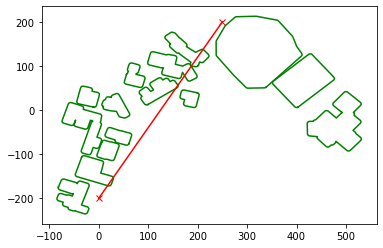

In [225]:
start = np.array([0, -200])
end = np.array([250, 200])

for poly in polys:
  plt.plot(poly[:, 0], poly[:, 1], 'g')

plt.plot([start[0], end[0]], [start[1], end[1]], 'rx-')

plt.show()

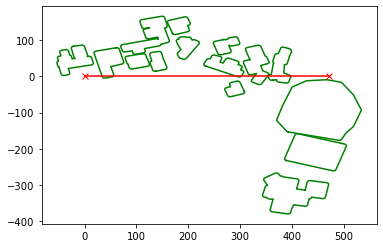

In [227]:
# Convex Hull method
# Firstly rotating coordinate system about the axis to make the start-end line the new X-axis

theta = np.arctan((end[1]-start[1])/(end[0]-start[0])) # in radian

T_r = np.array([[np.cos(theta), np.sin(theta), 0], [-np.sin(theta), np.cos(theta), 0], [0, 0, 1]]) # rotation matrix
T_t = np.array([[1, 0, -start[0]], [0, 1, -start[1]], [0, 0, 1]]) # translation matrix

T_tf = T_r @ T_t

new_polys = []

for poly in polys:
  new_points = []
  for row in poly:
    aug_row = np.append(row, 1)
    output_row = T_tf @ aug_row
    new_points.append(np.delete(output_row, 2, axis=0))
      
  new_poly = np.array(new_points)
  
  plt.plot(new_poly[:, 0], new_poly[:, 1], 'g')
  new_polys.append(new_poly)
  
aug_start = np.append(start, 1)
aug_end = np.append(end, 1)

out_start = np.delete(T_tf @ aug_start, 2, axis=0)
out_end = np.delete(T_tf @ aug_end, 2, axis=0)

plt.plot([out_start[0], out_end[0]], [out_start[1], out_end[1]], 'rx-')
plt.show()

In [228]:
# Now trying to keep only intersecting polygons
# Current implementation with shapely

from shapely.geometry import Point, Polygon, LineString, MultiPoint

path = LineString([out_start, out_end])
inter_polys = [] # Shapely polygons
vicinity_polys = []
start_point = Point(out_start)
end_point = Point(out_end)

for poly in new_polys:
  polygon = Polygon(poly)
  if path.distance(polygon) < (path.length**(1/2)):
    vicinity_polys.append(polygon)
  if path.intersects(polygon):
    print("intersected")
    inter_polys.append(polygon)

intersected
intersected
intersected
intersected


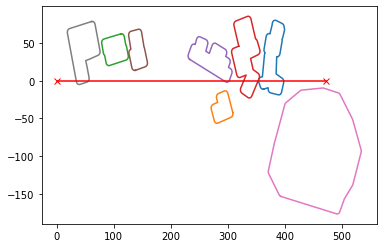

In [229]:
for poly in vicinity_polys:
  plt.plot(*poly.exterior.xy)

plt.plot([start_point.x, end_point.x], [start_point.y, end_point.y], 'rx-')
plt.show()

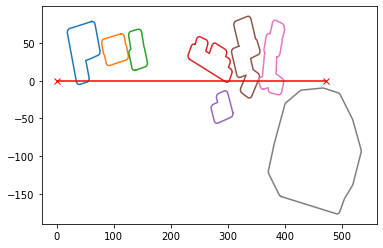

In [230]:
# Sorting polygons by distance to start point
inter_polys = sorted(inter_polys, key = lambda x: Point(0,0).distance(x))
vicinity_polys = sorted(vicinity_polys, key = lambda x: Point(0,0).distance(x))

for poly in vicinity_polys:
  plt.plot(*poly.exterior.xy)

plt.plot([start_point.x, end_point.x], [start_point.y, end_point.y], 'rx-')
plt.show()

In [231]:
node_dict = {} # dictionary of all nodes corresponding to coordinates, num_poly*10000+num_vertex

# All polygonal nodes
for i, poly in enumerate(vicinity_polys):
  for j, point in enumerate(poly.exterior.coords):
    node_num = (i+1)*10000 + (j % (len(poly.exterior.coords)-1)) + 1
    node_dict[point] = node_num

# Start and end nodes
node_dict[(start_point.x, start_point.y)] = 0
node_dict[(end_point.x, end_point.y)] = 1

inv_node_dict = {v: k for k, v in node_dict.items()}

In [232]:
# efficient implementation of dijkstra's algo

from collections import defaultdict
from heapq import *

def dijkstra(edges, f, t):
    g = defaultdict(list)
    for l,r,c in edges:
        g[l].append((c,r))

    q, seen, mins = [(0,f,())], set(), {f: 0}
    while q:
        (cost,v1,path) = heappop(q)
        if v1 not in seen:
            seen.add(v1)
            path = (v1, path)
            if v1 == t: 
              out = (cost, path)
              make_path = lambda tup: (*make_path(tup[1]), tup[0]) if tup else ()
              return out[0], make_path(out[1])

            for c, v2 in g.get(v1, ()):
                if v2 in seen: continue
                prev = mins.get(v2, None)
                next = cost + c
                if prev is None or next < prev:
                    mins[v2] = next
                    heappush(q, (next, v2, path))

    return float("inf"), None
  
# edges = [(start, end, cost), ...]  
# make_path = lambda tup: (*make_path(tup[1]), tup[0]) if tup else ()
# out = dijkstra(edges, start, end)
# path = make_path(out[1])

In [233]:
# Visibility graph trial
import itertools

visibility_edges = []

total_points = list(start_point.coords) + list(end_point.coords)
for poly in vicinity_polys:
  total_points = total_points + list(poly.exterior.coords)

for pair in itertools.combinations(total_points, 2):
  edge = LineString(pair)
  nodes = sorted([node_dict[point] for point in pair])
  if nodes[0] == 1:
    nodes.reverse()
  
  poly_ids = [(node_dict[point] // 10000) for point in pair if (node_dict[point] // 10000)]
    
  flag = False
  for i, poly in enumerate(vicinity_polys):
    if edge.crosses(poly) or poly.contains(edge):
      flag = True
#       print('edge intersects')
      
  if flag is False: # ie edge is intersection-free
#     print('add')
    visibility_edges.append((nodes[0], nodes[1], Point(pair[0]).distance(Point(pair[1]))))

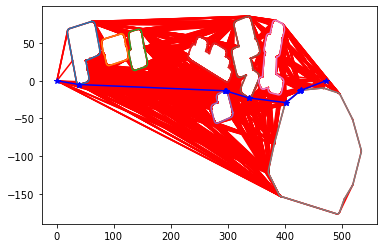

In [234]:
for edge in visibility_edges:
  point0 = inv_node_dict[edge[0]]
  point1 = inv_node_dict[edge[1]]
  plt.plot([point0[0], point1[0]], [point0[1], point1[1]], 'r-')
  
for poly in vicinity_polys:
  plt.plot(*poly.exterior.xy)
  
shortest_path = dijkstra(visibility_edges, 0, 1)

for i, j in zip(shortest_path[1], shortest_path[1][1:]):
  point0 = inv_node_dict[i]
  point1 = inv_node_dict[j]
  plt.plot([point0[0], point1[0]], [point0[1], point1[1]], 'b*-')

In [255]:
# Creating convex hulls and adding them to free-space graph
def chull_pathfinder(start_point, end_point, inter_polys, vicinity_polys, node_dict):

  fs_graph = []
  ref_line = LineString([start_point, end_point])# slope is flat
  above_dist = 0
  below_dist = 0
  above_point = None
  below_point = None

  extreme_points = [start_point] # first run

  # in-between runs
  for i in range(len(inter_polys)+1):
    poly = inter_polys[i] if i < len(inter_polys) else inter_polys[-1] # last polygon twice
    if i == len(inter_polys): # last run?
      extreme_points = [end_point]

    above_point = None
    above_dist = 0
    below_point = None
    below_dist = 0

    for ext_point in extreme_points:
      iteration_points = MultiPoint(list(poly.exterior.coords) + list(ext_point.coords))
      c_hull = iteration_points.convex_hull
      for j, point in enumerate(c_hull.exterior.coords):
        # extreme point checking only if it is a part of the obstacle
        if point in poly.exterior.coords:
          # distance from reference line
          dist = Point(point).distance(ref_line)
          # determine if point above or below line
          if point[1] > 0: #above
            if above_point is None:
              above_point = Point(point)
              above_dist = dist
            elif dist > above_dist:
              above_point = Point(point)
              above_dist = dist
          else:
            if below_point is None:
              below_point = Point(point)
              below_dist = dist
            elif dist > below_dist:
              below_point = Point(point)
              below_dist = dist

        # loop through edges and add to free space graph
        if j < len(c_hull.exterior.coords)-1:
          flag = False
          coord0 = point
          coord1 = c_hull.exterior.coords[j+1]
          # order by smaller first
          if (coord0[0]**2 + coord0[1]**2) > (coord1[0]**2 + coord1[1]**2):
            coord0, coord1 = coord1, coord0

          edge = LineString([coord0, coord1])
          nodes = [node_dict[coord0], node_dict[coord1]]
          if nodes[0] == 1:
            nodes.reverse()

          sub_inter_polys = [] # polygons intersected by the edge
#           sub_vicinity_polys  = []
          
          for obstacle in inter_polys: # TODO: confirm whether all polygons need to be checked
  #           if edge.intersects(obstacle) and obstacle is not sorted_polys[i]:
            if edge.crosses(obstacle):
  #             print('edge intersects')
              flag = True
              sub_inter_polys.append(obstacle)
#             if edge.distance(obstacle) < (edge.length**(1/2)):
#               sub_vicinity_polys.append(obstacle)

          if flag is False: # ie edge is intersection-free
            fs_graph.append((nodes[0], nodes[1], Point(coord0).distance(Point(coord1))))
          else:
            sub_graph = chull_pathfinder(Point(coord0), Point(coord1), sub_inter_polys, vicinity_polys, node_dict)
            fs_graph = fs_graph + sub_graph

    extreme_points = [above_point, below_point]
  
  return fs_graph

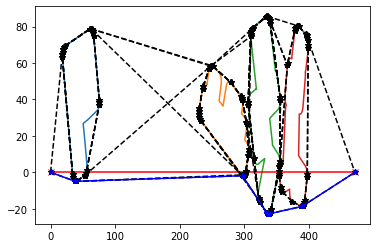

In [256]:
# drawing all polys to visualize    

for poly in inter_polys:
  plt.plot(*poly.exterior.xy)

plt.plot([start_point.x, end_point.x], [start_point.y, end_point.y], 'rx-')

graph = chull_pathfinder(start_point, end_point, inter_polys, vicinity_polys, node_dict)
shortest_path = dijkstra(graph, 0, 1)

for edge in graph:
  point0 = inv_node_dict[edge[0]]
  point1 = inv_node_dict[edge[1]]
  plt.plot([point0[0], point1[0]], [point0[1], point1[1]], 'k*--')

for i, j in zip(shortest_path[1], shortest_path[1][1:]):
  point0 = inv_node_dict[i]
  point1 = inv_node_dict[j]
  plt.plot([point0[0], point1[0]], [point0[1], point1[1]], 'b*-')

plt.show()